## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import time
import datetime as dt
import urllib.request, json
import os
from pandas_datareader import data
import tweepy
from textblob import TextBlob
import re

Using TensorFlow backend.


## Getting data using Alpha Vantage API

In [2]:
data_source = 'alphavantage'

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '7TONQ8CM5PXZ4YEO'

    # INFY stock market prices
    ticker = "INFY"

    # JSON file with all the stock market data for INFY from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

File already exists. Loading data from CSV


In [3]:
df = pd.read_csv("stock_market_data-INFY.csv")

In [4]:
df = df[['Date', 'Open', 'Close', 'Low', 'High']]

In [5]:
df = df.sort_values('Date')

In [6]:
df.head()

,Date,Open,Close,Low,High
2113,1999-03-11,38.50,46.88,37.38,50.00
1553,1999-03-12,47.00,46.63,43.00,48.75
2874,1999-03-15,46.75,42.38,42.13,46.75
976,1999-03-16,42.75,42.00,42.00,44.25
4249,1999-03-17,42.00,42.25,41.75,44.75


In [7]:
df.tail()

,Date,Open,Close,Low,High
2910,2018-09-28,10.22,10.1700,10.120,10.25
2607,2018-10-01,10.34,10.3700,10.295,10.39
1412,2018-10-02,10.32,10.2700,10.200,10.32
1142,2018-10-03,10.12,10.0400,10.010,10.15
3330,2018-10-04,10.12,9.8511,9.800,9.92


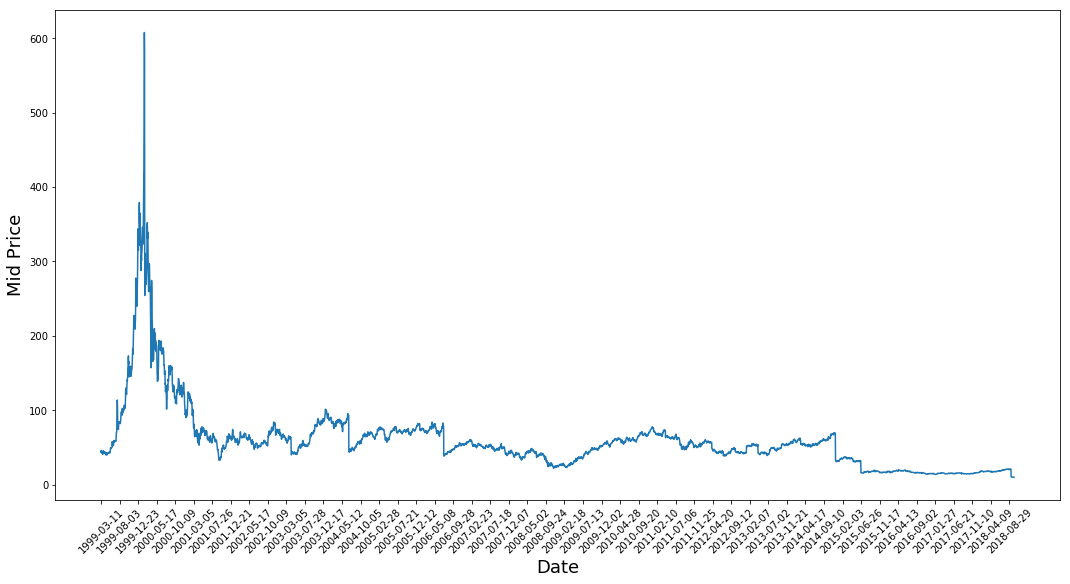

In [8]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [9]:
high_prices = df.loc[:,'High']
low_prices = df.loc[:,'Low']
df["Mid Prices"] = (high_prices+low_prices)/2.0

In [10]:
df.head()

,Date,Open,Close,Low,High,Mid Prices
2113,1999-03-11,38.50,46.88,37.38,50.00,43.690
1553,1999-03-12,47.00,46.63,43.00,48.75,45.875
2874,1999-03-15,46.75,42.38,42.13,46.75,44.440
976,1999-03-16,42.75,42.00,42.00,44.25,43.125
4249,1999-03-17,42.00,42.25,41.75,44.75,43.250


## Data Cleaning

In [11]:
df.drop("Date", axis = 1,inplace = True)

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
scaler.fit(df)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
df = scaler.transform(df)

## Building Long-Short Term Memory Cell to implement Recurrent Neural Network

In [15]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(None, layers[0]),
        units=50,
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        100,
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    start = time.time()
    model.compile(loss='mse', optimizer='rmsprop')
    print ('compilation time : ', time.time() - start)
    return model

## Load data as per model requirements

In [16]:
def load_data(stock, seq_len):
    amount_of_features = 5
    data = stock
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result =  np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [17]:
window = 5
X_train, y_train, X_test, y_test = load_data(df, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (4428, 5, 5)
y_train (4428,)
X_test (492, 5, 5)
y_test (492,)


In [18]:
model = build_model([5,window,1])

compilation time :  0.0636599063873291


## Training Time!

In [30]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=50,
    validation_split=0.1,
    verbose=1)

Train on 3985 samples, validate on 443 samples
Epoch 1/50
3985/3985 [==============================] - 1s 263us/step - loss: 0.0624 - val_loss: 0.0100
Epoch 2/50
3985/3985 [==============================] - 1s 253us/step - loss: 0.0436 - val_loss: 0.0141
Epoch 3/50
3985/3985 [==============================] - 1s 268us/step - loss: 0.0458 - val_loss: 0.0058
Epoch 4/50
3985/3985 [==============================] - 1s 259us/step - loss: 0.0556 - val_loss: 9.5261e-04
Epoch 5/50
3985/3985 [==============================] - 1s 294us/step - loss: 0.0401 - val_loss: 0.0121
Epoch 6/50
3985/3985 [==============================] - 1s 258us/step - loss: 0.0529 - val_loss: 0.0091
Epoch 7/50
3985/3985 [==============================] - 1s 250us/step - loss: 0.0424 - val_loss: 0.0139
Epoch 8/50
3985/3985 [==============================] - 1s 243us/step - loss: 0.0429 - val_loss: 0.0106
Epoch 9/50
3985/3985 [==============================] - 1s 251us/step - loss: 0.0452 - val_loss: 0.0013
Epoch 10/50
3

In [31]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print(trainScore)

0.0141532601734


## Predictions

In [32]:
p = model.predict(X_test)

## Visualizations

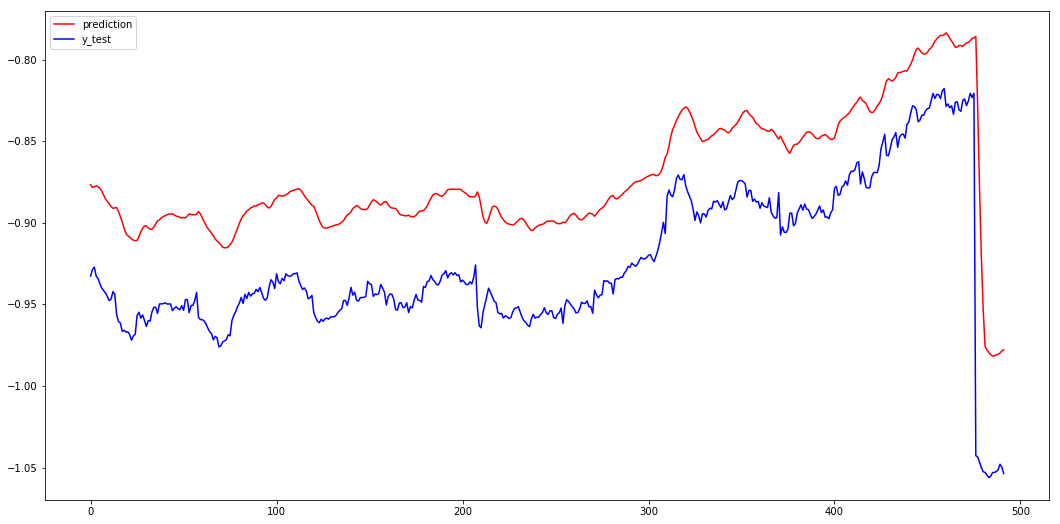

In [33]:
import matplotlib.pyplot as plt2
plt2.figure(figsize = (18,9))
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

## Sentiment Analysis

In [23]:
consumer_key= 'E0pFYVai9VaOhqLiRBEC6gpGF'
consumer_secret= 'XAMh4l9XL5nwFK3MN5tAjtXA2YgDN1tw5f7L2n6dz5ib8VYlbm'

access_token='3261604734-86c7DOJP98GwNeFWzvgPQKFUTyHn1ZFwlloJP3v'
access_token_secret='eXEmlEAdxaFjueVP03jsAWeOeNMkI7ToiDQkyvLDa6eX7'

In [24]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [25]:
public_tweets = api.search('Infosys', count = 1000)

In [26]:
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [27]:
def get_tweet_sentiment(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [28]:
positive = 0
negative = 0
neutral = 0
print(len(public_tweets))
for tweet in public_tweets:
#     print(tweet.text)
    print(clean_tweet(tweet.text))
    sentiment = get_tweet_sentiment(tweet.text) 
    print(sentiment)
    if sentiment == 'positive':
        positive += 1
    elif sentiment == 'negative':
        negative += 1
    elif sentiment == 'neutral':
        neutral += 1
    print("")

100
RT too To do what exactly 1 We have design expertise most of whom work for foreign co
positive

Finacle Launches Suite of New Digital Engagement Tools
positive

RT Verizon Infosys Slave Trade US Employees Worst Affected
negative

RT We thank Infosys for continuing its longstanding partnership with the government We signed an agreement with them toda
neutral

Create By com gif infosys gifgoodnight
neutral

RT JCID President and JCID Co founder Skyler Mattson and Client Partnerships Director Kinley Lagrange ready to take the stage at
positive

You idiot Kerala govt is just following and enforcing the SC verdict If SC will give ruling on other religions K
negative

Verizon severance offer goes to about 44 000 employees via Indian
neutral

Infosys PuneDC
neutral

RT Infosys is a premier sponsor at UiPathForward Americas Meet our experts at booth 19 to learn about our customer exper
neutral

4years And the journey endzz It s time to leave It s been 4 wonderful year s with Infosys And it

In [29]:
print('Positive:', positive)
print('Negative:', negative)
print('Neutral:', neutral)

Positive: 34
Negative: 11
Neutral: 55
